This project allows you to convert the photo of a generic sheet music into MusicXML format.

How does it do this?

It uses a neural network that can recognize objects (in this case notes, rests, etc.) and by means of sorting algorithms and the position of the latter to do a complete sorting. Through a parser the objects are then converted into MusicXML notations.

Authors:
- Pietro Negri
- Antonio Cacciapuoti
- Giovanni Rapa

Musimathics Lab, UNISA 2023

# 0 - Mount Drive partition
Checks on the GPU we will be using and gdrive mouting. To use CUDA you need a GPU, you have to request it on Colab (T4 GPU).

In [ ]:
# Check GPU Availability
gpu_info = !nvidia-smi  # Execute the nvidia-smi command to get GPU information
gpu_info = '\n'.join(gpu_info)  # Convert the GPU information into a string

# Check if GPU is available
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

# Mount Google Drive
from google.colab import drive  # Import the drive module from the google.colab library
drive.mount('/content/gdrive')  # Mount Google Drive to the /content/gdrive directory

Mon Oct  2 16:10:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1 - DarkNet installation
We need to install Darknet and OpenCv to recognize objects in scores.

In [ ]:
# Change the working directory to /content
%cd /content

# Remove the existing 'darknet' directory if it exists
!rm -r darknet

# Clone the Darknet repository
!git clone https://github.com/AlexeyAB/darknet

# Update and upgrade your system
!apt-get update
!apt-get upgrade

# Install necessary dependencies
!apt-get install build-essential
!apt-get install cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev
!apt-get install libavcodec-dev libavformat-dev libswscale-dev
!apt-get install libopencv-dev

# Change the directory to the 'darknet' folder
%cd darknet

# Modify the Makefile for Darknet to enable the desired configurations
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

# Build Darknet
!make

# Run Darknet (replace this with your own Darknet commands)
!./darknet

/content
rm: cannot remove 'darknet': No such file or directory
Cloning into 'darknet'...
remote: Enumerating objects: 15825, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 15825 (delta 148), reused 211 (delta 129), pack-reused 15539
Receiving objects: 100% (15825/15825), 14.77 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (10578/10578), done.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [517 kB]
Get:8 http://secur

# 2 - Set Yolo Configuration
We need to set configurations for Yolo in order to properly train. There are few settings which we need to change in the default yolov3.cfg file.

- batch
- subdivisions (if you get memory out error, increase this 16, 32 or 64)
- max_batches (it should be classes*2000)
- steps (it should be 80%, 90% of max_batches)
- classes (the number of classes which you are going to train)
- filters (the value for filters can be calculated using (classes + 5)x3 )

Change the values below as per your requirement.

In [ ]:
# List the contents of the current directory
!ls

# Calculate anchors for your custom dataset
!./darknet detector calc_anchors data/obj.data -num_of_clusters 9 -width 800 -height 800 -show

3rdparty		data		       obj
backup			docker-compose.yml     package.xml
build			Dockerfile.cpu	       README.md
build.ps1		Dockerfile.gpu	       results
cfg			image_yolov3.sh        scripts
cmake			image_yolov4.sh        src
CMakeLists.txt		include		       vcpkg.json
darknet			json_mjpeg_streams.sh  vcpkg.json.opencv23
DarknetConfig.cmake.in	LICENSE		       video_yolov3.sh
darknet_images.py	Makefile	       video_yolov4.sh
darknet.py		net_cam_v3.sh
darknet_video.py	net_cam_v4.sh
 CUDA-version: 11080 (12000), cuDNN: 8.9.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4

 num_of_clusters = 9, width = 800, height = 800 
Couldn't open file: data/obj.data


In [ ]:
# Modify YOLOv3-SPP configuration file (yolov3-spp.cfg) using sed commands

# Set batch size to 64
!sed -i 's/batch=1/batch=64/g' cfg/yolov3-spp.cfg

# Set subdivisions to 32
!sed -i 's/subdivisions=1/subdivisions=32/g' cfg/yolov3-spp.cfg

# Adjust input width and height to 800x800
!sed -i 's/width=608/width=800/g' cfg/yolov3-spp.cfg
!sed -i 's/height=608/height=800/g' cfg/yolov3-spp.cfg

# Set max_batches to 116000
!sed -i 's/max_batches = 500200/max_batches = 116000/g' cfg/yolov3-spp.cfg

# Adjust training steps
!sed -i 's/steps=400000,450000/steps=92800,104400/g' cfg/yolov3-spp.cfg

# Set the number of classes to 58
!sed -i 's/classes=80/classes=58/g' cfg/yolov3-spp.cfg

# Adjust the number of filters to 189
!sed -i 's/filters=255/filters=189/g' cfg/yolov3-spp.cfg

# Display the modified configuration file
!cat cfg/yolov3-spp.cfg

[net]
# Testing
batch=64
subdivisions=32
# Training
# batch=64
# subdivisions=326
width=800
height=800
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 116000
policy=steps
steps=92800,104400
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutio

# 3 - Get and unzip the DataSet

In [ ]:
import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')

DOWNLOAD_LOCATION = '/content/darknet/data/'
DRIVE_DATASET_FILE = '/content/gdrive/MyDrive/ASMC/PentaKey/mlYOLO/PentaKey_yolo.zip' # adjust path/name of dataset which is in your G-drive

shutil.copy(DRIVE_DATASET_FILE, DOWNLOAD_LOCATION)

# Print a success message indicating that the dataset has been successfully downloaded
print('Successfully downloaded the dataset')

Successfully downloaded the dataset


In [ ]:
# List the contents of the current directory
!ls

# Unzip the "PentaKey_yolo.zip" file into the "./data" directory
!unzip data/PentaKey_yolo.zip -d ./data

3rdparty		data		       obj
backup			docker-compose.yml     package.xml
build			Dockerfile.cpu	       README.md
build.ps1		Dockerfile.gpu	       results
cfg			image_yolov3.sh        scripts
cmake			image_yolov4.sh        src
CMakeLists.txt		include		       vcpkg.json
darknet			json_mjpeg_streams.sh  vcpkg.json.opencv23
DarknetConfig.cmake.in	LICENSE		       video_yolov3.sh
darknet_images.py	Makefile	       video_yolov4.sh
darknet.py		net_cam_v3.sh
darknet_video.py	net_cam_v4.sh
Archive:  data/PentaKey_yolo.zip
   creating: ./data/img/
  inflating: ./data/__MACOSX/._img   
  inflating: ./data/img/psr_e263_ypt_260_multi_songbook_r1-102.jpg  
  inflating: ./data/__MACOSX/img/._psr_e263_ypt_260_multi_songbook_r1-102.jpg  
  inflating: ./data/img/score2_19.png  
  inflating: ./data/__MACOSX/img/._score2_19.png  
  inflating: ./data/img/la.jpg       
  inflating: ./data/__MACOSX/img/._la.jpg  
  inflating: ./data/img/LA_2-1-restyled.jpg  
  inflating: ./data/__MACOSX/img/._LA_2-1-restyled.jpg

#4 - Download initial pre-trained weights for the convolutional layers (If you have already trained and saved the weights to your Google drive, you can skip this)

In [ ]:
# Download the darknet53.conv.74 file if you haven't already (commented)
#!wget https://pjreddie.com/media/files/darknet53.conv.74

import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')

DARKNET_DIR = '/content/darknet/'
DRIVE_DIR = '/content/gdrive/My Drive/PentaKey/mlYOLO/darknet53.conv.74' # adjust path in your Google Drive, or keep it default

# Copy the darknet53.conv.74 file from Google Drive to the local directory
shutil.copy(DRIVE_DIR, DARKNET_DIR)

# Print a message indicating the location where convolutional layers were saved
print('Saved convolutional layers to local space at: ' + DARKNET_DIR)

#5 - Start the training

It will take a long time to complete...

Note: If during the training you see NaN values for avg (loss) field then the training will go wrong, but if NaN is found elsewhere then training will go well.

- file yolo-obj_last.weights will be saved to the darknet/backup for each 100 iterations
- file yolo-obj_xxxx.weights will be saved to the darknet/backup for each 1000 iterations
- After each 100 iterations, if you want, you can stop and later start training from this point. For example, after 2000 iterations you can stop training, and later just start training using: darknet detector train data/obj.data yolov3.cfg backup/yolo-obj_2000.weights

In [ ]:
# List the contents of the current directory
!ls

# Copy the yolov3-spp_final.weights file from Google Drive to the cfg/ directory
shutil.copy("/content/gdrive/My Drive/PentaKey/PentaKey/yolov3-spp_final.weights", "/content/darknet/cfg/")

# Copy the yolov3-spp_final.weights file from Google Drive to the current directory
shutil.copy("/content/gdrive/My Drive/PentaKey/PentaKey/yolov3-spp_final.weights", "/content/")

# Copy the darknet53.conv.74 file from Google Drive to the current directory
shutil.copy("/content/gdrive/My Drive/PentaKey/mlYOLO/darknet53.conv.74", "/content/")

# Train a YOLOv3-SPP model using the specified configuration and weights
# Use this line to retrain your previous saved weights
!./darknet detector train data/obj.data cfg/yolov3-spp.cfg /content/yolov3-spp_final.weights -dont_show

#6 - Dump Model to drive (Optional)
Once you have trained your model, you can save them to your Google drive. So that next time, you don't need to retrain.

In [ ]:
# Check if Google Drive is mounted; if not, mount it
if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')

# Define the source path for the YOLOv3-SPP backup weights
YOLO_BACKUP = '/content/darknet/backup/yolov3-spp_last.weights' # Adjust the backup file name or keep it default

# Define the destination directory in Google Drive
DRIVE_DIR = '/content/gdrive/My Drive/mlYOLO/' # Adjust the path in your Google Drive, or keep it default

# Copy the YOLOv3-SPP backup weights to Google Drive
shutil.copy(YOLO_BACKUP, DRIVE_DIR)

# Print a message indicating the location where the training data was saved
print('Saved training data to drive at: ' + DRIVE_DIR)

# 7 - Importing the weights

In [ ]:
# Check if Google Drive is mounted; if not, mount it
if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')

# Define the source file path in Google Drive
DRIVE_DIR = '/content/gdrive/My Drive/ASMC/PentaKey/PentaKey/yolov3-spp_final.weights' # Adjust the path in your Google Drive, or keep it default

# Define the destination directory in the local file system
YOLO_BACKUP = '/content/darknet/backup/' # Adjust the backup file name or keep it default

# Copy the file from Google Drive to the local directory
shutil.copy(DRIVE_DIR, YOLO_BACKUP)

# Print a message indicating the location where the training data was saved
print('Saved training data to the local directory at: ' + YOLO_BACKUP)

Saved training data to drive at: /content/gdrive/My Drive/ASMC/PentaKey/PentaKey/yolov3-spp_final.weights


In [ ]:
# Calculate mAP (mean Average Precision) for the YOLOv3-SPP model
# - `data/obj.data`: Path to the data file
# - `cfg/yolov3-spp.cfg`: Path to the configuration file
# - `backup/yolov3-spp_final.weights`: Path to the weight file

!./darknet detector map data/obj.data cfg/yolov3-spp.cfg backup/yolov3-spp_final.weights

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    800 x 800 x   3 ->  800 x 800 x  32 1.106 BF
   1 conv     64       3 x 3/ 2    800 x 800 x  32 ->  400 x 400 x  64 5.898 BF
   2 conv     32       1 x 1/ 1    400 x 400 x  64 ->  400 x 400 x  32 0.655 BF
   3 conv     64       3 x 3/ 1    400 x 400 x  32 ->  400 x 400 x  64 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 400 x 400 x  64 0.010 BF
   5 conv    128       3 x 3/ 2    400 x 400 x  64 ->  200 x 200 x 128 5.898 BF
   6 conv     64       1 x 1/ 1    200 x 200 x 128 ->  200 x 200 x  64 0.655 BF
   7 conv    128       3 x 3/ 1    200 x 200 x  64 ->  200 x 200 x 128 5.89

#8 - Predict

In [ ]:
# Perform object detection using YOLOv3-SPP model
# - `data/obj.data`: Path to the data file
# - `cfg/yolov3-spp.cfg`: Path to the configuration file
# - `/content/gdrive/MyDrive/ASMC/PentaKey/PentaKey/yolov3-spp_final.weights`: Path to the weight file
# - `data/img/fratelli_d_italia.png`: Path to the input image
# - `-thresh 0.1`: Detection threshold set to 0.1
# - `-out risultato.json`: Output results to a file named "risultato.json"

!./darknet detector test data/obj.data cfg/yolov3-spp.cfg /content/gdrive/MyDrive/ASMC/PentaKey/PentaKey/yolov3-spp_final.weights data/img/fratelli_d_italia.png -thresh 0.1 -out risultato.json

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    800 x 800 x   3 ->  800 x 800 x  32 1.106 BF
   1 conv     64       3 x 3/ 2    800 x 800 x  32 ->  400 x 400 x  64 5.898 BF
   2 conv     32       1 x 1/ 1    400 x 400 x  64 ->  400 x 400 x  32 0.655 BF
   3 conv     64       3 x 3/ 1    400 x 400 x  32 ->  400 x 400 x  64 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 400 x 400 x  64 0.010 BF
   5 conv    128       3 x 3/ 2    400 x 400 x  64 ->  200 x 200 x 128 5.898 BF
   6 conv     64       1 x 1/ 1    200 x 200 x 128 ->  200 x 200 x  64 0.655 BF
   7 conv    128       3 x 3/ 1    200 x 200 x  64 ->  200 x 200 x 128 5.89

In [ ]:
# Download the "risultato.json" file to your local machine
from google.colab import files

files.download('risultato.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 9 - Display the results
Show the JPEG with the prediction made (with each prediction the file predictions.jpg is changed)

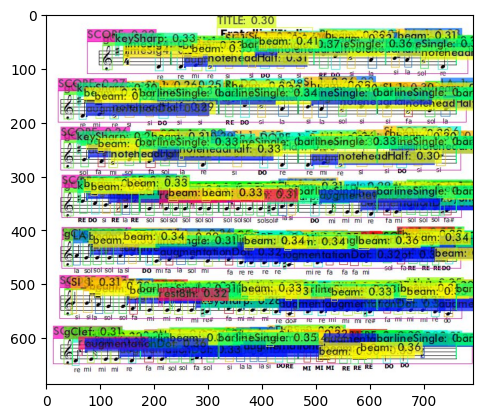

In [ ]:
# Import necessary libraries
import cv2
import matplotlib.pyplot as plt
import os.path

# Define the display_image function
def display_image(file_path='/content/darknet/predictions.jpg'):
    # Check if the file exists at the specified path
    if os.path.exists(file_path):
        # Read the image using OpenCV
        img = cv2.imread(file_path)

        # Convert BGR to RGB color format for Matplotlib
        show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.imshow(show_img)
    else:
        print('Failed to open file')

# Call the display_image function
display_image()

# 10 - Converting it all to MusicXML
To effectively perform this task, please refer to the project's repository at https://github.com/blazQ/dolores.